<a href="https://colab.research.google.com/github/briangasca/Models/blob/xgboost/XGBoost_Model_Ver_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Stacking / Blending Model

[0]	validation_0-rmse:8.85495	validation_1-rmse:10.80594
[100]	validation_0-rmse:0.89053	validation_1-rmse:18.97042
[0]	validation_0-rmse:212.58604	validation_1-rmse:23.17450
[100]	validation_0-rmse:54.24451	validation_1-rmse:15.72022
[0]	validation_0-rmse:3.05659	validation_1-rmse:9.97123
[100]	validation_0-rmse:0.04715	validation_1-rmse:7.84615
[0]	validation_0-rmse:11.14361	validation_1-rmse:27.31700
[100]	validation_0-rmse:1.32602	validation_1-rmse:54.14491
[0]	validation_0-rmse:49.59226	validation_1-rmse:13.87852
[100]	validation_0-rmse:23.96319	validation_1-rmse:15.60778
[0]	validation_0-rmse:10.74674	validation_1-rmse:10.23369
[100]	validation_0-rmse:0.16706	validation_1-rmse:19.79335
[0]	validation_0-rmse:1.41020	validation_1-rmse:13.62019
[100]	validation_0-rmse:0.18962	validation_1-rmse:12.95110
[0]	validation_0-rmse:20.85769	validation_1-rmse:24.90319
[100]	validation_0-rmse:3.96957	validation_1-rmse:47.47684
[0]	validation_0-rmse:11.11891	validation_1-rmse:12.87313
[100]	va

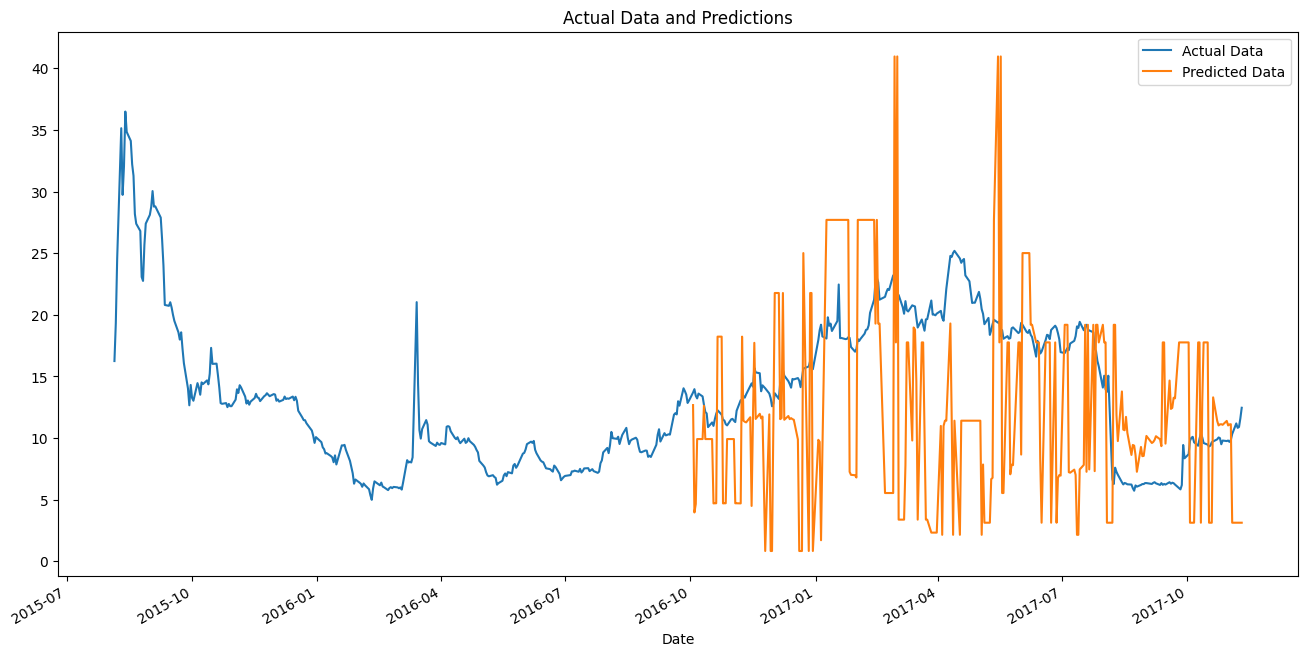

Ensemble MSE: 86.46563135164139
Ensemble RMSE: 9.298689765318628


In [130]:
# W.I.P., amplitudes are off but the basic graph shape is there.
# Imports
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

# Set up variables
palette = sb.color_palette()

# Initialize datasets
stockDatasets = ["yrd.us.txt", "yten.us.txt", "ytra.us.txt", "yum.us.txt", "yuma.us.txt",
                 "yumc.us.txt", "yume.us.txt", "yy.us.txt", "z.us.txt", "zagg.us.txt",
                 "zais.us.txt", "zayo.us.txt", "zb_a.us.txt", "zb_g.us.txt", "zb_h.us.txt",
                 "zbh.us.txt", "zbio.us.txt", "zbk.us.txt", "zbra.us.txt", "zbzx.us.txt",
                 "zdge.us.txt", "zeal.us.txt", "zen.us.txt", "zeus.us.txt", "zf.us.txt",
                 "zfgn.us.txt", "zg.us.txt", "zgnx.us.txt", "zion.us.txt", "zionw.us.txt",
                 "zionz.us.txt", "ziop.us.txt", "zixi.us.txt", "zjzzt.us.txt", "zkin.us.txt",
                 "zlab.us.txt", "zn.us.txt", "znga.us.txt", "znh.us.txt", "zoes.us.txt",
                 "zsan.us.txt", "zto.us.txt", "ztr.us.txt", "zts.us.txt", "zumz.us.txt"
                 ]

dfs = []

zyne_df = pd.read_csv("zyne.us.txt")
zyne_df = zyne_df.set_index("Date")
zyne_df.index = pd.to_datetime(zyne_df.index)

for dataset in stockDatasets:
  df = pd.read_csv(dataset)
  df = df.set_index("Date")
  df.index = pd.to_datetime(df.index)
  dfs.append(df)

# Split data
train_sets = []
test_set = zyne_df.loc[zyne_df.index >= "2016-10-01"]

for df in dfs:
  train_sets.append(df)

# Give train_sets weight based on graph to predict future prices of
train_predicting_set = zyne_df.loc[zyne_df.index < "2016-10-01"]
weight = len(stockDatasets) // 2

# weight mechanic, W.I.P.
for i in range(weight):
  train_sets.append(train_predicting_set)

# Create time series from datasets
def create_features(df):
  df = df.copy()
  df["hour"] = df.index.hour
  df["dayofweek"] = df.index.dayofweek
  df["quarter"] = df.index.quarter
  df["month"] = df.index.month
  df["year"] = df.index.year
  df["dayofyear"] = df.index.dayofyear

  return df

for i in range(len(dfs)):
  dfs[i] = create_features(dfs[i])

# Convert datasets to time series and prepare data
for i in range(len(train_sets)):
  train_sets[i] = create_features(train_sets[i])

test_set = create_features(test_set)

FEATURES = ["hour", "dayofweek", "quarter", "month", "year", "dayofyear"]
TARGET = "Close"

X_train_samples = []
y_train_samples = []

# Initialize train_sets with X_train samples and y_train samples
for train_set in train_sets:
  X_train = train_set[FEATURES]
  X_train_samples.append(X_train)

  y_train = train_set[TARGET]
  y_train_samples.append(y_train)

X_test_sample = test_set[FEATURES]
y_test_sample = test_set[TARGET]

# Initialize the models
models = []

for i in range(len(train_sets)):
  if i < len(stockDatasets):
    reg_model = xgb.XGBRegressor(n_estimators = 101,
                                early_stopping_rounds = 500,
                                learning_rate = 0.69,
                                max_depth = 2,
                                subsample = 0.999,
                                reg_lambda = 0.901,
                                eta = 0,
                                )
  else:
    reg_model = xgb.XGBRegressor(n_estimators = 101,
                                early_stopping_rounds = 500,
                                learning_rate = 0.69,
                                max_depth = 2,
                                subsample = 0.999,
                                reg_lambda = 0.901,
                                eta = 0,
                                )

  reg_model.fit(X_train_samples[i], y_train_samples[i],
                eval_set = [(X_train_samples[i], y_train_samples[i]), (X_test_sample, y_test_sample)],
                verbose = 100)

  models.append(reg_model)

# Visualize feature importance
fi = pd.DataFrame(data = reg_model.feature_importances_,
                  index = reg_model.feature_names_in_,
                  columns = ["importance"])

# Forecast stock prices
ensemble_predictions = []

for model in models:
  prediction = model.predict(X_test_sample)
  ensemble_predictions.append(prediction)

# Stacking / Blending Algorithm
final_prediction = []

for i in range(len(X_test_sample)):
  closest_prediction_idx = np.argmin([abs(pred[i] - train_predicting_set['Close'][i]) for pred in ensemble_predictions])
  closest_prediction = ensemble_predictions[-closest_prediction_idx][i]
  final_prediction.append(closest_prediction)

for i in range(len(final_prediction)):
  '''
  if final_prediction[i] > 15:
    final_prediction[i] = math.sqrt(final_prediction[i])
  elif final_prediction[i] <= 15:
    final_prediction[i] += 10

  if final_prediction[i] > 30:
    final_prediction[i] /= 2
  elif final_prediction[i] < 5:
    final_prediction[i] *= 4

  final_prediction[i] /= 2
  final_prediction[i] += 5
  '''

# Gradient Descent Testing
def gradient_descent(gradient, start, learn_rate, n_iter):
  vector = start
  for _ in range(n_iter):
      diff = -learn_rate * gradient(vector)
      vector += diff
  return vector

gd_test = gradient_descent(np.cos, final_prediction, 0.7, 1000)

# Visualize predictions (All the code below needs to be cleaned up, especially zyne.df file management :P)
test_set["prediction"] = final_prediction
zyne_df = zyne_df.merge(test_set[["prediction"]], how = "left", left_index = True, right_index = True)

ax = zyne_df[["Close"]].plot(figsize = (16, 8))
zyne_df["prediction"].plot(ax = ax)
plt.legend(["Actual Data", "Predicted Data"])
ax.set_title("Actual Data and Predictions")
plt.show()

# Evaluate Accuracy (definitely not working)
#ensemble_mse = mean_squared_error(y_test_sample, final_prediction)
ensemble_mse = mean_squared_error(test_set["Close"], test_set["prediction"])
print("Ensemble MSE:", ensemble_mse)
ensemble_rmse = np.sqrt(ensemble_mse)
print("Ensemble RMSE:", ensemble_rmse)

In [104]:
# Gradient Descent Testing
def gradient_descent(gradient, start, learn_rate, n_iter):
  vector = start
  for _ in range(n_iter):
      diff = -learn_rate * gradient(vector)
      vector += diff
  return vector

gd_test = gradient_descent(np.sqrt, final_prediction, 0.01, 10)
gd_test

array([11.00448799, 12.57756411, 13.93183008,  9.64752955,  9.64752955,
        9.64752955, 10.97655745,  9.64752955,  9.64752955,  9.64752955,
        9.64752955, 14.0261639 , 14.04695877, 14.04695877, 13.74159333,
       13.74159333, 14.0261639 , 14.04695877, 14.04695877,  9.64752955,
        9.64752955,  9.64752955,  9.64752955, 14.04695877, 14.04695877,
       14.0261639 , 13.74159333, 10.37906091, 10.33763599, 10.3140904 ,
       10.51876522, 13.62137507, 10.51572035, 13.49382417, 10.45074333,
       10.65543845, 10.47544505, 10.54770166,  6.4246308 , 10.63234204,
        6.4246308 ,  6.4246308 , 10.44162376, 15.48874636, 15.48874636,
       10.4427775 , 10.48305185, 15.48874636, 10.41807637, 10.56768829,
       10.4427775 , 10.48305185, 10.44162376, 10.41807637,  9.63168338,
        6.4246308 ,  6.4246308 ,  6.4246308 , 17.08849986,  6.4246308 ,
       15.48874636, 15.48874636,  6.4246308 ,  9.61805003,  9.53522082,
        8.14057251,  9.19679696, 18.41933016, 18.41933016, 18.41

In [ ]:
test_set["Close"]

Date
2016-10-03    13.70
2016-10-04    13.97
2016-10-05    13.43
2016-10-06    13.22
2016-10-07    13.61
              ...  
2017-11-06    11.19
2017-11-07    10.83
2017-11-08    10.90
2017-11-09    11.60
2017-11-10    12.46
Name: Close, Length: 281, dtype: float64

In [ ]:
test_set["prediction"]

Date
2016-10-03    12.677940
2016-10-04     3.967482
2016-10-05     4.653918
2016-10-06     9.921773
2016-10-07     9.921773
                ...    
2017-11-06     3.134782
2017-11-07     3.134782
2017-11-08     3.134782
2017-11-09     3.134782
2017-11-10     3.134782
Name: prediction, Length: 281, dtype: float32

In [ ]:
final_prediction

In [ ]:
## Optimizing XGBoost ##
# Define the hyperparameter grid
max_depth_options = []
learning_rate_options = []
subsample_options = []
num_parallel_tree_options = []

for i in range(1, 4):
  max_depth_options.append(i)

for i in range(60, 90):
  learning_rate_options.append(i / 100)

for i in range(95, 101):
  subsample_options.append(i / 100)

for i in range(1, 30):
  num_parallel_tree_options.append(i)

param_grid = {
    'n_estimators': [101],
    'learning_rate': [0.69],
    'max_depth': [2],
    'subsample': [0.999],
    'reg_lambda': [0.901],
    'eta': [0],
    'num_parallel_tree': num_parallel_tree_options
}

# Create the GridSearchCV object
grid_search = GridSearchCV(reg_model, param_grid, cv=3, scoring="r2", error_score = "raise")

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

AssertionError: ignored

In [ ]:
test.groupby("date")["error"].mean().sort_values(ascending = False).head(5)

date
2022-01-03    446.590759
2022-01-04    396.400696
2021-11-04    384.496582
2021-11-05    376.676514
2021-11-03    364.760193
Name: error, dtype: float64

In [ ]:
test.groupby("date")["error"].mean().sort_values(ascending = True).head(5)

date
2021-07-12    1.249817
2021-10-15    2.383423
2022-01-28    2.532410
2021-08-18    2.666748
2021-07-30    3.936523
Name: error, dtype: float64

In [ ]:
''' This code will mirror the first half of the graph to the second half of the graph
for i in range(len(X_test_sample)):
  closest_prediction_idx = np.argmin([abs(pred[i] - train_predicting_set['Close'][-i]) for pred in ensemble_predictions])
  closest_prediction = ensemble_predictions[closest_prediction_idx][i]
  final_prediction.append(closest_prediction)
'''

''' This code will copy the first half of the graph to the second half of the graph
for i in range(len(X_test_sample)):
  closest_prediction_idx = np.argmin([abs(pred[i] - train_predicting_set['Close'][i]) for pred in ensemble_predictions])
  closest_prediction = ensemble_predictions[closest_prediction_idx][i]
  final_prediction.append(closest_prediction)
'''